

# Yield Curve Construction

In this case study we use principal component analysis (PCA) to generate the typical movements of a yield curve 

## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)
    * [4.3.Data Transformation](#3.2)  
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train Test Split](#4.1)
    * [5.2. Model Evaluation- Applying Principle Component Analysis](#4.2)
        * [5.2.1. Explained Variance using PCA](#4.2.1)
        * [5.2.2. Finding the Best Eigen Portfolio](#4.2.2)
        * [5.2.3. Backtesting Eigenportfolio](#4.2.3)

<a id='0'></a>
# 1. Problem Definition

Our goal in this case study is to use dimensionality reduction techniques to generate
the “typical” movements of a yield curve.
The data used for this case study is obtained from Quandl. 

Quandl is a premier
source for financial, economic and alternative datasets. We use the data of 11 tenors
(from 1 month to 30 years) of the treasury curves. The frequency of the data is daily
and the data is available from 1960 onwards



<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [2]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

#Import Model Packages 
from sklearn.decomposition import PCA

<a id='1.2'></a>
## 2.2. Loading the Data

In [ ]:
import pkg_resources
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'quandl'}
# missing = required - installedPackages
if 'quandl' not in installedPackages:
    !pip install quandl #==3.4
    import quandl

In [ ]:
#The API Key can be optained from Quandl website by registering. 
quandl.ApiConfig.api_key = 'QUANDL_API_KEY'

In [ ]:
treasury = ['FRED/DGS1MO',
           'FRED/DGS3MO',
           'FRED/DGS6MO',
           'FRED/DGS1',
           'FRED/DGS2',
           'FRED/DGS3',
           'FRED/DGS5',
           'FRED/DGS7',
           'FRED/DGS10',
           'FRED/DGS20',
           'FRED/DGS30']

treasury_df = quandl.get(treasury)
treasury_df.columns = ['TRESY1mo',
                'TRESY3mo', 
                'TRESY6mo',
                'TRESY1y',
                'TRESY2y',
                'TRESY3y',
                'TRESY5y',
                'TRESY7y',
                'TRESY10y',
                'TRESY20y',
                'TRESY30y']
dataset = treasury_df

In [4]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
thisiscolab = False
working_dir = '../../data/'
if thisiscolab:
    from google.colab import drive
    drive.mount('/content/drive')
    root_dir = '/content/drive/MyDrive/Colab Notebooks/hanbit_mlfi/'
    root_dir = root_dir + 'Ch7_ULDR/CS2YCCIRM'
    from os import chdir
    chdir(root_dir)

Mounted at /content/drive


In [6]:
# load dataset
dataset = pd.read_csv(working_dir+'DownloadedData.csv',index_col=0)
type(dataset)

pandas.core.frame.DataFrame

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [7]:
# shape
dataset.shape

(4078, 8)

In [8]:
# peek at data
pd.set_option('display.width', 100)
dataset.tail(5)

,SWAP1,SWAP2,SWAP3,SWAP4,SWAP5,SWAP7,SWAP10,SWAP30
DATE,,,,,,,,
2016-10-24,0.99,1.08,1.15,1.22,1.30,1.43,1.61,1.96
2016-10-25,1.00,1.08,1.15,1.22,1.29,1.42,1.59,1.93
2016-10-26,1.01,1.10,1.18,1.25,1.33,1.47,1.64,1.98
2016-10-27,1.00,1.11,1.20,1.29,1.38,1.53,1.71,2.07
2016-10-28,1.00,1.10,1.19,1.28,1.36,1.52,1.71,2.07


In [9]:
# types
pd.set_option('display.max_rows', 500)
dataset.dtypes

SWAP1     float64
SWAP2     float64
SWAP3     float64
SWAP4     float64
SWAP5     float64
SWAP7     float64
SWAP10    float64
SWAP30    float64
dtype: object

In [10]:
# describe data
pd.set_option('precision', 3)
dataset.describe()

,SWAP1,SWAP2,SWAP3,SWAP4,SWAP5,SWAP7,SWAP10,SWAP30
count,4078.000,4078.000,4078.000,4078.000,4078.000,4078.000,4078.000,4078.000
mean,2.106,2.390,2.688,2.953,3.181,3.535,3.873,4.395
std,1.913,1.832,1.766,1.700,1.637,1.535,1.446,1.331
min,0.250,0.340,0.420,0.560,0.730,1.100,1.280,1.670
25%,0.490,0.780,1.060,1.370,1.660,2.140,2.552,3.190
50%,1.330,1.800,2.310,2.770,3.125,3.610,4.070,4.620
75%,3.507,3.920,4.198,4.450,4.580,4.830,5.020,5.390
max,7.130,7.220,7.250,7.270,7.290,7.320,7.360,7.300


<a id='2.2'></a>
## 3.2. Data Visualization

Let us look at the movement of the yield curve. 

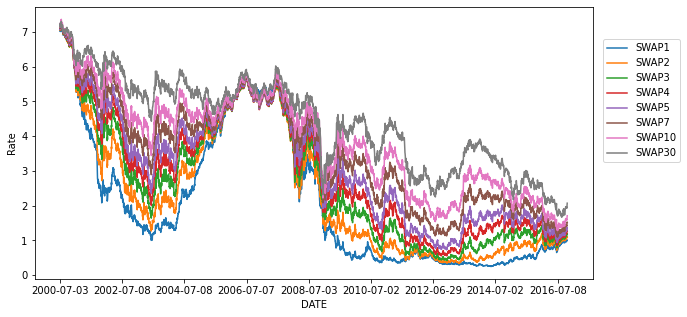

In [11]:
dataset.plot(figsize=(10,5))
plt.ylabel("Rate")
plt.legend(bbox_to_anchor=(1.01, 0.9), loc=2)
plt.show()

In the next step we look at the correlation.

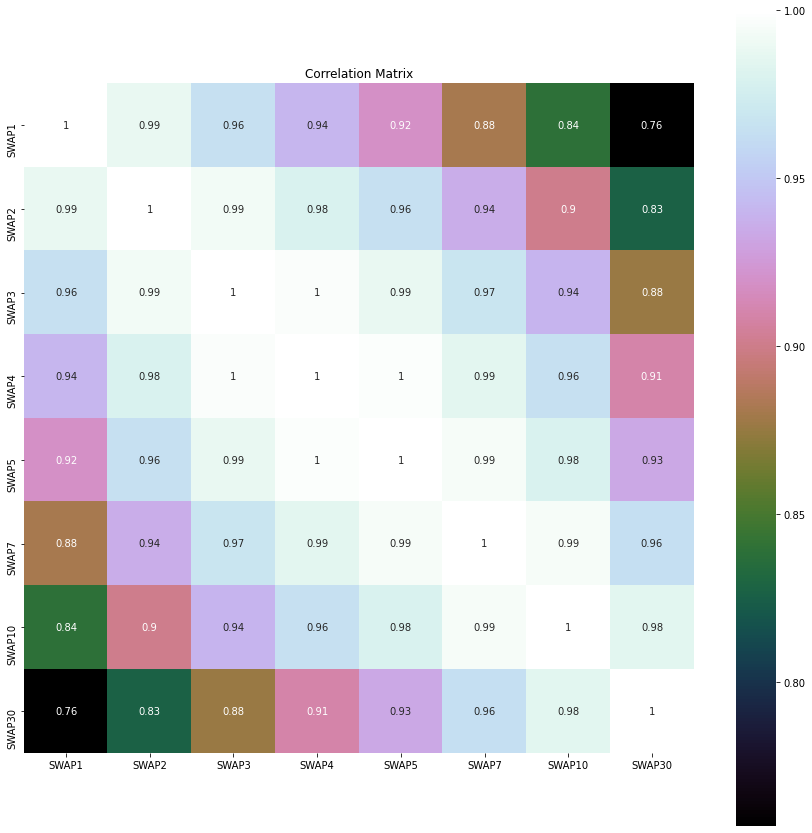

In [12]:
# correlation
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

As it can be seen by the picture above there is a significant positive correlation between the stocks. 

<a id='3'></a>
## 4. Data Preparation

<a id='3.1'></a>
## 4.1. Data Cleaning
We check for the NAs in the data, either drop them or
fill them with the mean of the column and the steps are same as mentioned in previ‐
ous case studies.

In [13]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


Given that there are null values drop the rown contianing the null values.

In [14]:
# Fill the missing values with the last value available in the dataset. 
dataset=dataset.fillna(method='ffill')

# Drop the rows containing NA
dataset= dataset.dropna(axis=0)
# Fill na with 0
#dataset.fillna('0')

dataset.head(2)

,SWAP1,SWAP2,SWAP3,SWAP4,SWAP5,SWAP7,SWAP10,SWAP30
DATE,,,,,,,,
2000-07-03,7.10,7.16,7.17,7.17,7.17,7.20,7.24,7.24
2000-07-05,7.03,7.06,7.07,7.07,7.08,7.11,7.14,7.16


<a id='3.2'></a>
## 4.2. Data Transformation

All the variables should be on the same scale before applying PCA, otherwise a feature with large values will dominate the result. We use StandardScaler in sklearn to standardize the dataset’s features onto unit scale (mean = 0 and variance = 1).

In [15]:
scaler = StandardScaler().fit(dataset)
rescaledDataset = pd.DataFrame(scaler.fit_transform(dataset),columns = dataset.columns, index = dataset.index)
# summarize transformed data
dataset.dropna(how='any', inplace=True)
rescaledDataset.dropna(how='any', inplace=True)
rescaledDataset.head(2)

,SWAP1,SWAP2,SWAP3,SWAP4,SWAP5,SWAP7,SWAP10,SWAP30
DATE,,,,,,,,
2000-07-03,2.610,2.604,2.538,2.481,2.437,2.388,2.329,2.138
2000-07-05,2.574,2.549,2.482,2.423,2.382,2.330,2.260,2.078


__Visualising the standardised dataset__

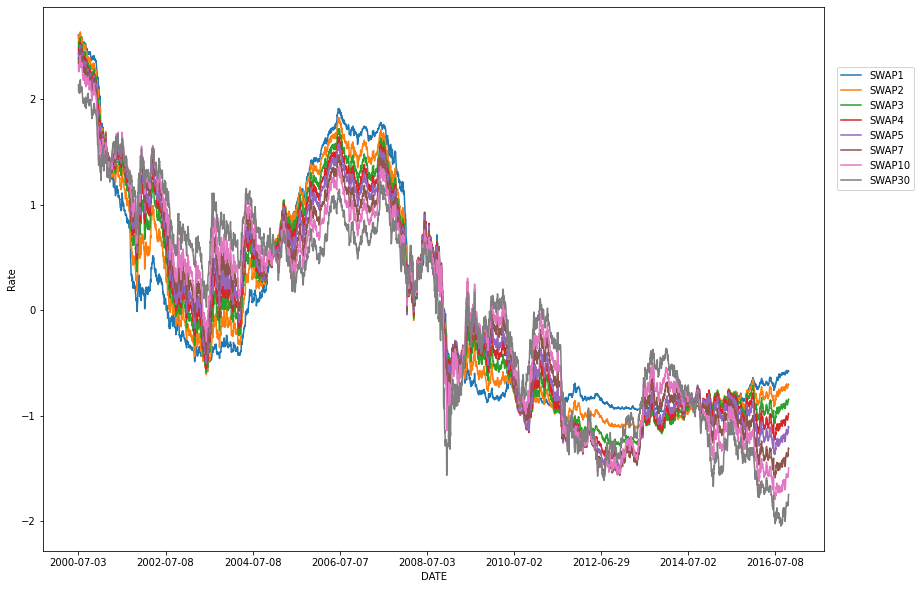

In [16]:
rescaledDataset.plot(figsize=(14,10))
plt.ylabel("Rate")
plt.legend(bbox_to_anchor=(1.01, 0.9), loc=2)
plt.show()

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.2'></a>
## 5.2. Model Evaluation- Applying Principle Component Analysis

As the next step We create a function to compute Principle Component Analysis from Sklearn. This function computes an inversed elbow chart that shows the amount of principle components and how many of them explain the variance treshold.

In [17]:
pca = PCA()
PrincipalComponent=pca.fit(rescaledDataset)

<a id='4.2.1'></a>
## 5.2.1.Explained Variance using PCA

,Explained Variance_Top 5
0,94.96%
1,99.63%
2,99.96%
3,100.00%
4,100.00%


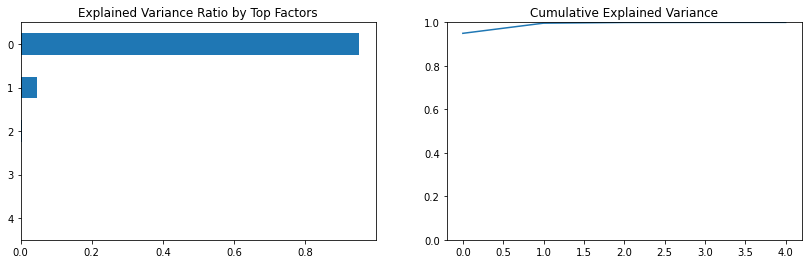

In [18]:
NumEigenvalues=5
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]).sort_values().plot.barh(title='Explained Variance Ratio by Top Factors',ax=axes[0]);
pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]).cumsum().plot(ylim=(0,1),ax=axes[1], title='Cumulative Explained Variance');

# explained_variance
pd.Series(np.cumsum(pca.explained_variance_ratio_)).to_frame('Explained Variance_Top 5').head(NumEigenvalues).style.format('{:,.2%}'.format)

Indeed, the first principal component accounts for 84.4% of variance, with the second principal component getting 98.44% and the third 99.53%. The first 3 principal components account for, cumulatively, 99.5% of all movements in the data. Hence, in terms of dimensionality reduction, the first 3 principal components are representative of the data.

<a id='4.2.2'></a>
## 5.2.2. Intuition Behind the Principal Components

We
first have a function to determine the weights of each principal component. We then
perform the visualization of the principal components.

In [19]:
def PCWeights():
    '''
    Principal Components (PC) weights for each 28 PCs
    '''
    weights = pd.DataFrame()

    for i in range(len(pca.components_)):
        weights["weights_{}".format(i)] = pca.components_[i] / sum(pca.components_[i])

    weights = weights.values.T
    return weights

weights=PCWeights()

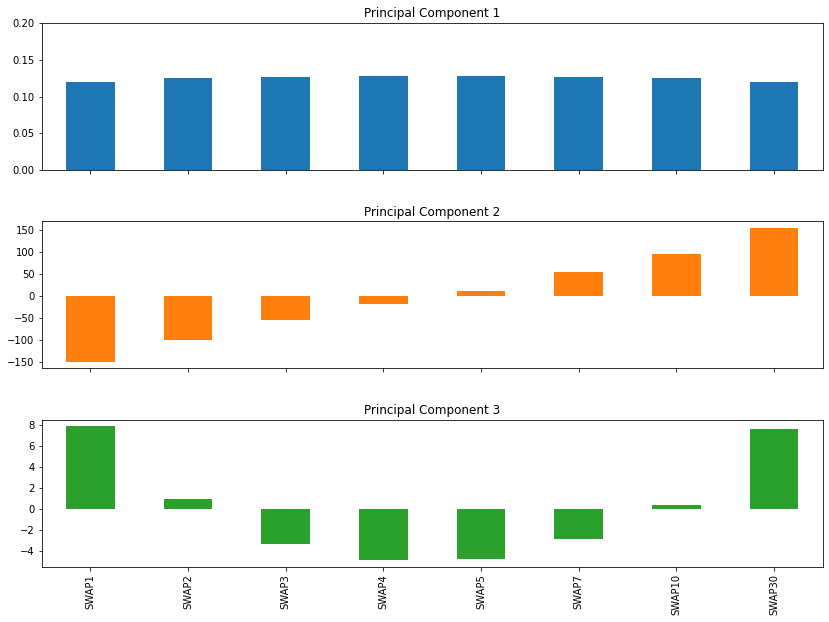

In [20]:
weights = PCWeights()
NumComponents=3    
        
topPortfolios = pd.DataFrame(weights[:NumComponents], columns=dataset.columns)
topPortfolios.index = [f'Principal Component {i}' for i in range(1, NumComponents+1)]

axes = topPortfolios.T.plot.bar(subplots=True, legend=False,figsize=(14,10))
plt.subplots_adjust(hspace=0.35)
axes[0].set_ylim(0, .2);

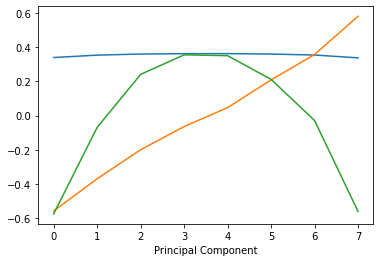

In [21]:
plt.plot(pca.components_[0:3].T)
plt.xlabel("Principal Component")
plt.show()

Looking at the the interpretation of the first three principal components, they correspond to:

__Principal Component 1__: Directional movements in the yield curve. These are movements that shift the entire yield curve up or down.

__Principal Component 2__: Slope movements in the yield curve. These are movements that steepen or flatten (change the first derivative wrt maturity) the entire yield curve.

__Principal Component 3__: Curvature movements in the yield curve. These are movements that change the curvature (or the second derivative wrt maturity) of the entire yield curve.

<a id='4.2.3'></a>
## 5.2.3. Reconstructing the curve using Principal Components

In [22]:
pca.transform(rescaledDataset)[:,:2]

array([[ 6.90444649, -0.39424533],
       [ 6.7452975 , -0.41306936],
       [ 6.86345795, -0.3974701 ],
       ...,
       [-3.16563695, -1.12490258],
       [-3.08780577, -1.06164871],
       [-3.10066989, -1.06006086]])

Using the simple matrix reconstruction, we can generate an approximation/almost exact replica of the initial data.

Mechanically PCA is just a matrix multiplication:

Y=XW,

where Y is your principal components, X is input data, and W is a matrix of coefficients.


The only trick here is that your matrix of coefficients is quite special: you can use it to recover the original matrix.

X=YW′,

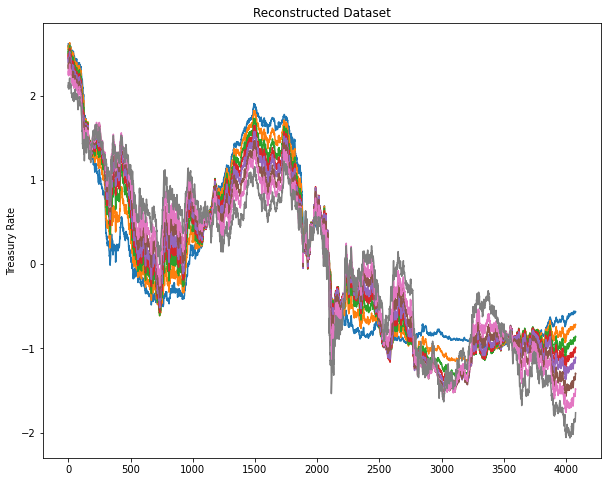

In [23]:
nComp=3
reconst= pd.DataFrame(np.dot(pca.transform(rescaledDataset)[:,:nComp], pca.components_[:nComp,:]),columns=dataset.columns)
plt.figure(figsize=(10,8))
plt.plot(reconst)
plt.ylabel("Treasury Rate")
plt.title("Reconstructed Dataset")
plt.show()

Figure above shows the replicated treasury rate chart.

__Conclusion__

We demonstrated the efficiency of dimensionality reduction and principal components analysis in reducing the number of dimension and coming up with new intuitive feature.


The first
three principal components explain more than 99.5% of the variation and represent
directional movements, slope movements, and curvature movements respectively.
Overall, by using principal component analysis, analyzing the eigen vectors and
understanding the intuition behind them, we demonstrated how the implementation
of a dimensionality reduction lead to fewer intuitive dimensions in the yield curve.
